# Аналитика в Яндекс.Афише

Вас пригласили на стажировку в отдел аналитики Яндекс.Афиши. Первое задание: помочь маркетологам оптимизировать маркетинговые затраты.
У вас в распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

## Описание данных

**/datasets/visits_log.csv.** — лог сервера с информацией о посещениях сайта:  
- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь 
 
**/datasets/orders_log.csv** — информация о заказах:
- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа

**/datasets/costs.csv** — информация о затратах на маркетинг:
- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

## Оглавление
1. [Шаг 1. Откройте файл с данными и изучите общую информацию](#step1)  
    1.1 [Вывод к Шагу 1](#step1.1)
    
        
2. [Шаг 2. Подготовка данных](#step2)  
    2.4  [Вывод к Шагу 2](#step2.1)     
  
    
3. [Шаг 3. Построим отчёты и посчитаем метрики](#step3)   
    3.1   [Продукт. Сколько людей пользуются в день, неделю, месяц?](#step3.1)  
    3.2   [Продукт. Сколько сессий в день?](#step3.2)  
    3.3   [Продукт. Сколько длится одна сессия?](#step3.3)  
    3.4   [Продукт. Как часто люди возвращаются?](#step3.4)  
    3.5   [Продажи. Когда люди начинают покупать?](#step3.5)   
    3.6   [Продажи. Сколько раз покупают за период?](#step3.6)   
    3.7   [Продажи. Какой средний чек?](#step3.7)   
    3.8   [Продажи. Сколько денег приносят? (LTV)](#step3.8)  
    3.9   [Маркетинг. Сколько денег потратили? Всего / на каждый источник / по времени](#step3.9)   
    3.10  [Маркетинг. Сколько стоило привлечение одного покупателя из каждого источника?](#step3.10)   
    3.11  [Маркетинг. На сколько окупились расходы? (ROI)](#step3.11)     

 
4. [Шаг 4. Общий вывод](#step4)  

### Шаг 1. Откройте файлы с данными и изучите общую информацию <a id="step1"></a>   
</div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from scipy import stats as st
from math import factorial
import numpy as np
from functools import reduce
import seaborn as sns


In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
display(visits.head(10))
print(visits.info())
print()

orders = pd.read_csv('/datasets/orders_log.csv')
display(orders.head(10))
print(orders.info())
print()

costs = pd.read_csv('/datasets/costs.csv')
display(costs.head(10))
print(costs.info())
print()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None



,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None



,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
None



### Вывод<a id="step1.1"></a>   
</div>  

Мы получили датасет без пропущенных значений, есть небольшие проблемы с названием столбцов (верхний регистр и пробелы). Для стобцов с датами изменим формат с `object` на `datetime`. Дополнительно проверим датасет на дубликаты. 

### Шаг 2. Предобработка данных <a id="step2"></a>   
</div>  

Начнём с **visits**. Выведем названия столбцов

In [3]:
print(visits.columns)

Index(['Device', 'End Ts', 'Source Id', 'Start Ts', 'Uid'], dtype='object')


Изменим названия, уберём пробелы и верхний регистр.

In [4]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']


Изменим тип данных у `end_ts` и `start_ts` (с точностью до секунды)

In [5]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format = '%Y-%m-%d %H:%M:%S')
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format = '%Y-%m-%d %H:%M:%S')

Проверим всё ли правильно

In [6]:
visits.info()
visits.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


Для удобства работы переместим столбец `uid` в начало, а `end_ts` в конец

In [7]:
visits = visits[['uid', 'device', 'source_id',  'start_ts', 'end_ts']]
display(visits.head(5))

,uid,device,source_id,start_ts,end_ts
0,16879256277535980062,touch,4,2017-12-20 17:20:00,2017-12-20 17:38:00
1,104060357244891740,desktop,2,2018-02-19 16:53:00,2018-02-19 17:21:00
2,7459035603376831527,touch,5,2017-07-01 01:54:00,2017-07-01 01:54:00
3,16174680259334210214,desktop,9,2018-05-20 10:59:00,2018-05-20 11:23:00
4,9969694820036681168,desktop,3,2017-12-27 14:06:00,2017-12-27 14:06:00


Проверим наличие дубликатов и какие есть значения в столбцах `source_id` и `device`.

In [8]:
print('Количество дубликатов в visits:', visits.duplicated().sum())
display(visits[['source_id','device']].apply(lambda x: x.value_counts()).T.stack())

Количество дубликатов в visits: 0


source_id  1           34121.0
           2           47626.0
           3           85610.0
           4          101794.0
           5           66905.0
           6               6.0
           7              36.0
           9           13277.0
           10          10025.0
device     desktop    262567.0
           touch       96833.0
dtype: float64

Никаких артефактов не обнаружено, поэтому с **visits** закончили, теперь перейдём к **orders**. Выведем название столбцов

In [9]:
print(orders.columns)

Index(['Buy Ts', 'Revenue', 'Uid'], dtype='object')


Наблюдаются те же проблемы, что и в случае с **visits**. Поэтому опять изменим названия, изменим тип данных для дат (с точностью до секунды) и переместим уникальный номер в начало таблицы, а дату в конец.

In [10]:
orders.columns = ['buy_ts', 'revenue', 'uid']
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format = '%Y-%m-%d %H:%M:%S')
orders = orders[['uid', 'revenue', 'buy_ts']]


Проверим, нет ли дубликатов. И выведем часть таблицы на экран. Дополнительно выведем общую информацию



In [11]:
print('Количество дубликатов в orders:', orders.duplicated().sum())
display(orders.info())
display(orders.head(5))

Количество дубликатов в orders: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
uid        50415 non-null uint64
revenue    50415 non-null float64
buy_ts     50415 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


None

,uid,revenue,buy_ts
0,10329302124590727494,17.00,2017-06-01 00:10:00
1,11627257723692907447,0.55,2017-06-01 00:25:00
2,17903680561304213844,0.37,2017-06-01 00:27:00
3,16109239769442553005,0.55,2017-06-01 00:29:00
4,14200605875248379450,0.37,2017-06-01 07:58:00


От **orders** перейдём **costs**. Поступаем по аналогии: выводим на экран название столбцов.

In [12]:
display(costs.columns)

Index(['source_id', 'dt', 'costs'], dtype='object')

Здесь проблем с названием столбцов меньше. Для удобства чтения переименуем `dt` в `date`, изменим его формат методом to_datetime (с точностью до дня). И, как и делали выше, перемести дату в конец таблицы.

In [13]:
costs.columns = ['source_id', 'date', 'costs']
costs['date'] = pd.to_datetime(costs['date'], format = '%Y-%m-%d')
costs = costs[['source_id', 'costs', 'date']]

Проверим наличие дубликатов, проверим какие есть источники.

In [14]:
costs.duplicated().sum()
display(costs[['source_id']].apply(lambda x: x.value_counts()).T.stack())

source_id  5     364
           9     363
           3     363
           1     363
           10    363
           4     363
           2     363
dtype: int64

Обратим внимание, что источники 6 и 7 не фигурируют в затратах. Видимо они связаны с органическими переходами (хотя маловато для органики) и/или, к примеру, бартерной рекламой.  
Дополнительно посмотрим, что это за особенная такая строка у 5 источника.

In [15]:
display(costs['date'].value_counts().sort_values().head(1))
display(costs.loc[(costs['date'] > '2018-03-30') & (costs['date'] < '2018-04-03')])

2018-03-31    1
Name: date, dtype: int64

,source_id,costs,date
303,1,15.67,2018-04-02
666,2,90.86,2018-04-02
1029,3,317.38,2018-04-02
1392,4,65.09,2018-04-02
1755,5,0.70,2018-03-31
1756,5,63.05,2018-04-02
2119,9,12.44,2018-04-02
2482,10,21.25,2018-04-02


Что же, видимо такое бывает, просто 31 марта 2018 года были затраты только по одному рекламному источнику

Выведем первые 10 строк таблицы, а также общую информацию

In [16]:
costs.info()
display(costs.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
costs        2542 non-null float64
date         2542 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


,source_id,costs,date
0,1,75.20,2017-06-01
1,1,62.25,2017-06-02
2,1,36.53,2017-06-03
3,1,55.00,2017-06-04
4,1,57.08,2017-06-05
5,1,40.39,2017-06-06
6,1,40.59,2017-06-07
7,1,56.63,2017-06-08
8,1,40.16,2017-06-09
9,1,43.24,2017-06-10


Выделим из **visits** отдельные датасеты для `desktop` и `touch`

In [17]:
visits_desktop = visits.query('device == "desktop"').reset_index()
visits_touch = visits.query('device == "touch"').reset_index()
display(visits_desktop.head(5))
display(visits_touch.tail(5))

,index,uid,device,source_id,start_ts,end_ts
0,1,104060357244891740,desktop,2,2018-02-19 16:53:00,2018-02-19 17:21:00
1,3,16174680259334210214,desktop,9,2018-05-20 10:59:00,2018-05-20 11:23:00
2,4,9969694820036681168,desktop,3,2017-12-27 14:06:00,2017-12-27 14:06:00
3,5,16007536194108375387,desktop,5,2017-09-03 21:35:00,2017-09-03 21:36:00
4,6,6661610529277171451,desktop,1,2018-01-30 11:13:00,2018-01-30 12:09:00


,index,uid,device,source_id,start_ts,end_ts
96828,359386,18176348973341832326,touch,2,2017-09-15 21:14:00,2017-09-15 21:14:19
96829,359391,18304232853749481866,touch,2,2017-08-30 11:53:00,2017-08-30 11:53:19
96830,359394,18332905065174083046,touch,4,2017-11-06 08:00:00,2017-11-06 08:00:19
96831,359396,18370831553019119586,touch,1,2018-01-25 17:38:00,2018-01-25 17:38:19
96832,359399,18396128934054549559,touch,2,2017-09-10 13:13:00,2017-09-10 13:13:19


### Вывод <a id="step2.1"></a>   
</div>  

В датасете не обнаружено дубликатов и пропущенных значений. Самые существенные проблемы были с типом данных у столбцов датами, а также с самим названием столбцов.

Кроме этого обнаружили интересные, хоть и малозначительные по количеству переходов, источники, по которым не обнаружены затраты. 


Все проблемы улажены, вынесли устройства в отдельные таблицы и можем двигаться дальше. 



### Шаг 3. Построим отчёты и посчитаем метрики <a id="step3"></a>   
</div>  

### Продукт. Сколько людей пользуются в день, неделю, месяц?<a id="step3.1"></a>   
</div>  

Добавим в **visits** столбцы `date, week, month` 

In [18]:
for data in [visits, visits_desktop, visits_touch]:
    
    data['date'] = data['start_ts'].dt.date
    data['week'] = data['start_ts'].dt.week
    data['month'] = data['start_ts'].dt.month



Найдем ежедневную, еженедельную и ежемесячную аудиторию Яндекс.Афиши

In [19]:
for data in [visits, visits_desktop, visits_touch]:
    DAU = data.groupby('date').agg({'uid': 'nunique'}).mean()
    WAU = data.groupby('week').agg({'uid': 'nunique'}).mean()
    MAU = data.groupby('month').agg({'uid': 'nunique'}).mean()
    if data is visits:
        print('Общая аудитория')
    if data is visits_desktop:
        print('Аудитория desktop')
    if data is visits_touch:
        print('Аудитория touch')
        
    print('Ежедневная аудитория:', int(DAU), 'человек')
    print('Еженедельная аудитория:', int(WAU), 'человек')
    print('Ежемесячная аудитория:', int(MAU), 'человек')
    print()





Общая аудитория
Ежедневная аудитория: 907 человек
Еженедельная аудитория: 5825 человек
Ежемесячная аудитория: 23228 человек

Аудитория desktop
Ежедневная аудитория: 659 человек
Еженедельная аудитория: 4208 человек
Ежемесячная аудитория: 16724 человек

Аудитория touch
Ежедневная аудитория: 252 человек
Еженедельная аудитория: 1666 человек
Ежемесячная аудитория: 6825 человек



### Продукт. Сколько сессий в день?<a id="step3.2"></a>   
</div>

In [20]:
for data in [visits, visits_desktop, visits_touch]:
    session_count = data.groupby('date').agg({'uid': 'count'}).mean()
    if data is visits:
        print('Общее количество сессий', int(session_count.round(0)))

    if data is visits_desktop:
        print('Количество сессий с desktop', int(session_count.round(0)))

    if data is visits_touch:
        print('Количество сессий с touch', int(session_count.round(0)))      


Общее количество сессий 987
Количество сессий с desktop 721
Количество сессий с touch 267


### Продукт. Сколько длится одна сессия?<a id="step3.3"></a>   
</div>

Вычтем из времени окончании сессии время начала. С помощью метода describe рассмотрим новый столбец `session_duration_sec` 

In [21]:
for data in [visits, visits_desktop, visits_touch]:
    
    data['session_duration_sec'] = (data['end_ts'] - data['start_ts']).dt.seconds
    if data is visits:
        print('Метод describe для всех сессий')
    if data is visits_desktop:
        print('Метод describe для сессий с desktop')
    if data is visits_touch:
        print('Метод describe для сессий с touch') 
        
    print(data['session_duration_sec'].describe())
    print()

    
    

Метод describe для всех сессий
count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: session_duration_sec, dtype: float64

Метод describe для сессий с desktop
count    262567.000000
mean        703.946977
std        1091.545596
min           0.000000
25%         120.000000
50%         360.000000
75%         900.000000
max       84480.000000
Name: session_duration_sec, dtype: float64

Метод describe для сессий с touch
count    96833.000000
mean       479.619407
std        752.531533
min          0.000000
25%         60.000000
50%        180.000000
75%        600.000000
max      30840.000000
Name: session_duration_sec, dtype: float64



Построим гистограмму для длительности сессий

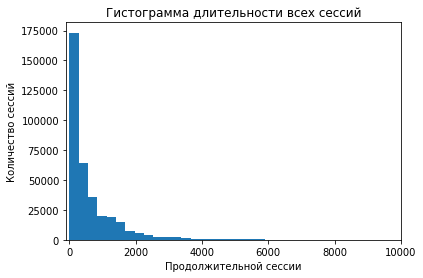

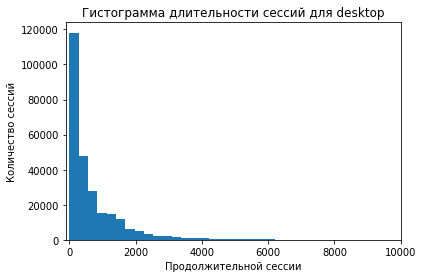

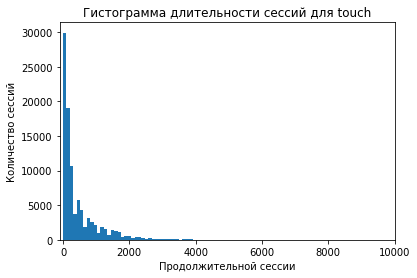

In [22]:
for data in [visits, visits_desktop, visits_touch]:
    if data is visits:
        plt.title('Гистограмма длительности всех сессий')
    if data is visits_desktop:
        plt.title('Гистограмма длительности сессий для desktop')
    if data is visits_touch:
        plt.title('Гистограмма длительности сессий для touch')
    plt.hist(data['session_duration_sec'], bins=300)
    plt.xlabel('Продолжительной сессии')
    plt.ylabel('Количество сессий')

    plt.xlim(-100,10000)
    plt.show()

Таким образом можно сделать вывод, что медианное значение для длительности сессии составляет ровно **300 секунд**. Среднее значение длительности - **644 секунды**.   
Для *desktop* медианная длительность справедливо увеличивается до **360 секунд**, а для *touch* - наоборот уменьшается до **180 секунд**. Это можно объяснить тем, что более углубленный поиск пользователи совершают чаще с компьютера, чем с телефона. 

### Продукт. Как часто люди возвращаются?<a id="step3.4"></a>   
</div>

Можно предположить, что большая часть пользователей обращаются к ресурсу не чаще, чем раз в месяц. Поэтому когорты будем формировать по данным за месяц. 

Найдём дату первой сессии, соберём это в объект Series `first_visit_date` и методом `join` добавим к нашей таблице

In [23]:
first_visit_date = visits.groupby(['uid'])['start_ts'].min()
first_visit_date.name = 'first_visit_date'
visits = visits.join(first_visit_date, on='uid')

first_visit_desktop_date = visits_desktop.groupby(['uid'])['start_ts'].min()
first_visit_desktop_date.name = 'first_visit_date'
visits_desktop = visits_desktop.join(first_visit_desktop_date, on='uid')

first_visit_touch_date = visits_touch.groupby(['uid'])['start_ts'].min()
first_visit_touch_date.name = 'first_visit_date'
visits_touch = visits_touch.join(first_visit_touch_date, on='uid')


#Оставил здесь цикл, который не стал работать из-за обращений к first_visit_date. 
#Честно говоря я так и не понял, почему он не работал 
#for data in [visits, visits_desktop, visits_touch]:
    #first_visit_date = data.groupby(['uid'])['start_ts'].min()
    #first_visit_date.name = 'first_visit_date'
    #data = data.join(first_visit_date, on='uid')


Приведём `first_visit_month и visit_month` к типу `datetime64[M]`, то есть с размерностью временной метки в месяц.

In [24]:
for data in [visits, visits_desktop, visits_touch]:
    data['first_visit_month'] = data['first_visit_date'].astype('datetime64[M]')
    data['visit_month'] = data['start_ts'].astype('datetime64[M]')

Теперь подсчитаем время жизни для будущей когорт

In [25]:
for data in [visits, visits_desktop, visits_touch]:
    data['lifetime'] = (data['visit_month'] - data['first_visit_month']) / np.timedelta64(1, 'M')
    data['lifetime'] = data['lifetime'].round().astype('int')

Сгруппируем данные по когорте и `lifetime`. Подсчитаем количество `uid`

for data in [visits, visits_desktop, visits_touch]:
    if data is visits:
    if data is visits_desktop:
    if data is visits_touch:

In [26]:
for data in [visits, visits_desktop, visits_touch]:
    cohorts = data.groupby(['first_visit_month','lifetime']).agg({'uid':'nunique'}).reset_index()
    if data is visits:
        cohorts_visits = cohorts
        print('Когорты всех сессий')
        display(cohorts_visits)
    if data is visits_desktop:
        cohorts_visits_desktop = cohorts
        print('Когорты desktop')
        display(cohorts_visits_desktop)
    if data is visits_touch:
        cohorts_visits_touch = cohorts
        print('Когорты touch')
        display(cohorts_visits_touch)


Когорты всех сессий


,first_visit_month,lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909
...,...,...,...
73,2018-03-01,1,861
74,2018-03-01,2,557
75,2018-04-01,0,15709
76,2018-04-01,1,760


Когорты desktop


,first_visit_month,lifetime,uid
0,2017-06-01,0,9761
1,2017-06-01,1,771
2,2017-06-01,2,541
3,2017-06-01,3,620
4,2017-06-01,4,678
...,...,...,...
73,2018-03-01,1,615
74,2018-03-01,2,381
75,2018-04-01,0,11055
76,2018-04-01,1,540


Когорты touch


,first_visit_month,lifetime,uid
0,2017-06-01,0,3655
1,2017-06-01,1,187
2,2017-06-01,2,112
3,2017-06-01,3,124
4,2017-06-01,4,152
...,...,...,...
73,2018-03-01,1,238
74,2018-03-01,2,147
75,2018-04-01,0,5311
76,2018-04-01,1,205


Подсчитаем исходное количество пользователей в когорте. Возьмём их число на нулевую неделю. После чего переименуем столбцы и объединим получившиеся данные с `cohorts`.

In [27]:
#Для всех сессий
initial_users_count_visits = cohorts_visits[cohorts_visits['lifetime'] == 0][['first_visit_month','uid']]
initial_users_count_visits = initial_users_count_visits.rename(columns={'uid':'cohort_users'})
cohorts_visits = cohorts_visits.merge(initial_users_count_visits,on='first_visit_month')

#Для desktop
initial_users_count_visits_d = cohorts_visits_desktop[cohorts_visits_desktop['lifetime'] == 0][['first_visit_month','uid']]
initial_users_count_visits_d = initial_users_count_visits_d.rename(columns={'uid':'cohort_users'})
cohorts_visits_desktop = cohorts_visits_desktop.merge(initial_users_count_visits_d,on='first_visit_month')

#Для touch
initial_users_count_visits_t = cohorts_visits_touch[cohorts_visits_touch['lifetime'] == 0][['first_visit_month','uid']]
initial_users_count_visits_t = initial_users_count_visits_t.rename(columns={'uid':'cohort_users'})
cohorts_visits_touch = cohorts_visits_touch.merge(initial_users_count_visits_t,on='first_visit_month')

                                          
                                          

Теперь рассчитаем *Retention Rate*, построим сводную таблицу и создадим тепловую карту

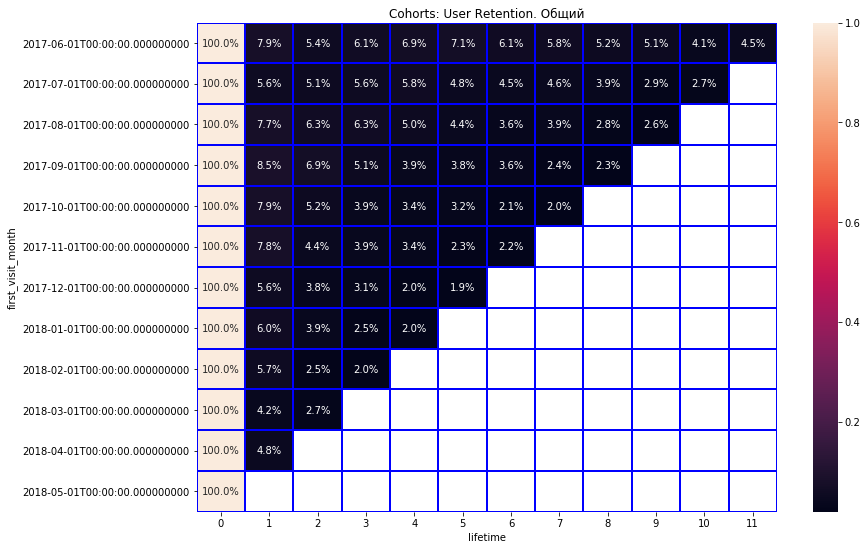

In [28]:
for cohorts in [cohorts_visits]:
    cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
    retention_pivot = cohorts.pivot_table(index='first_visit_month',columns='lifetime',values='retention',aggfunc='sum')
    plt.figure(figsize=(13, 9))
    plt.title('Cohorts: User Retention. Общий')
    sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='blue');

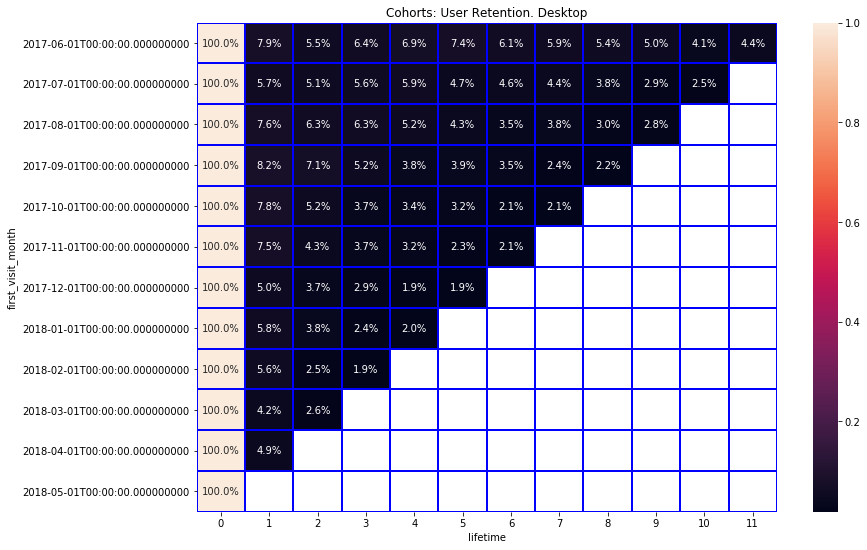

In [29]:
for cohorts in [cohorts_visits_desktop]:
    cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
    retention_pivot = cohorts.pivot_table(index='first_visit_month',columns='lifetime',values='retention',aggfunc='sum')
    plt.figure(figsize=(13, 9))
    plt.title('Cohorts: User Retention. Desktop')
    sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='blue');

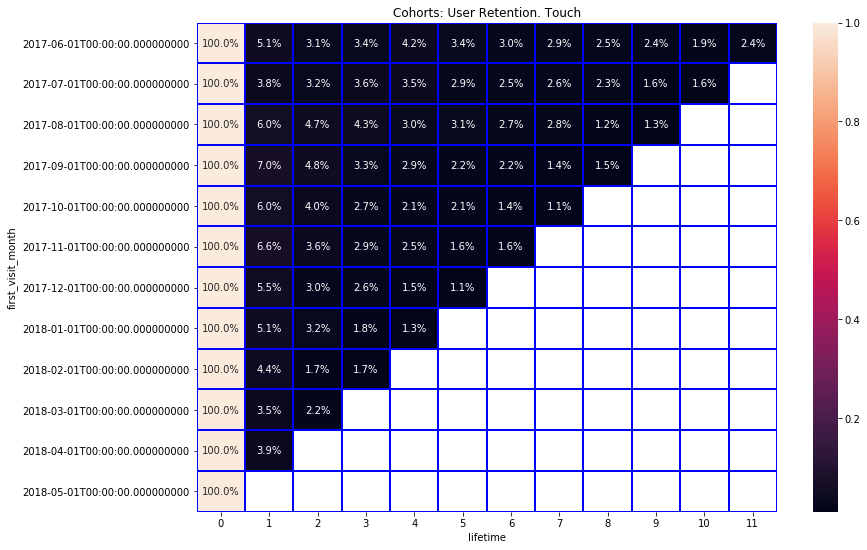

In [30]:
for cohorts in [cohorts_visits_touch]:
    cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
    retention_pivot = cohorts.pivot_table(index='first_visit_month',columns='lifetime',values='retention',aggfunc='sum')
    plt.figure(figsize=(13, 9))
    plt.title('Cohorts: User Retention. Touch')
    sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='blue');

Как видно из тепловой карты, большинство пользователей не возвращаются на следующий месяц, то есть более **92% пользователей не удерживаются** после первого использования.   
При этом оставшееся меньшинство значительно стабильнее возвращается к Яндекс.Афише. Да есть общий естественный спад, но он не так большой и составляет около **3 п.п.**  

Если *desktop* очень близок по содержанию к тепловой карте всех сессий, то у *touch* устройств заметно снижение по всем когортам в начале их существования на **2 п.п.**. Возможно, объяснение этому лежит в плоскости юзабилити *touch* версии Яндекс.Афиши. Есть версия, что не все устройства работают правильно с сайтом/приложением. На это стоит обратить внимание разработчиков.  



### Продажи. Когда люди начинают покупать?<a id="step3.5"></a>   
</div>

В начале сгруппируем таблицы **visits** и **orders** по дате первого визита и первой покупки соответственно.

In [31]:
first_visit = visits.groupby('uid').agg({'start_ts':'min'}).reset_index()
first_visit_desktop = visits_desktop.groupby('uid').agg({'start_ts':'min'}).reset_index()
first_visit_touch = visits_touch.groupby('uid').agg({'start_ts':'min'}).reset_index()
first_order = orders.groupby('uid').agg({'buy_ts':'min'}).reset_index()

Методом `merge` объединим получившиеся таблицы по столбцу `uid` в `buying_time` и выведём её первые 3 значения на экран.

In [32]:
buying_time = first_visit.merge(first_order, on='uid', how='inner')
buying_time_desktop = first_visit_desktop.merge(first_order, on='uid', how='inner')
buying_time_touch = first_visit_touch.merge(first_order, on='uid', how='inner')
for data in [buying_time, buying_time_desktop, buying_time_touch]:
    display(data.head(3))

,uid,start_ts,buy_ts
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00


,uid,start_ts,buy_ts
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00
1,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00
2,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00


,uid,start_ts,buy_ts
0,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
1,3077748354309989,2018-03-03 12:08:00,2018-03-03 12:33:00
2,4992223027560440,2018-04-04 13:54:00,2018-04-04 13:54:00


Подсчитаем время первой покупки. Для этого вычтем из времени совершения первой покупки `buy_ts` время первой сессии на сайте `start_ts`.

In [33]:
for data in [buying_time, buying_time_desktop, buying_time_touch]:
    data['buying_time'] = (data['buy_ts'] - data['start_ts']).dt.seconds


Изучим получившиеся столбец методом describe. Предварительно для удобства переведём секунды в минуты.

In [34]:
for data in [buying_time, buying_time_desktop, buying_time_touch]:
    data['buying_time'] = data['buying_time']/60
    if data is buying_time:
        print('Время совершения до первой покупки для всех сессий')
    if data is buying_time_desktop:
        print('Время совершения до первой покупки для desktop')
    if data is buying_time_touch:
        print('Время совершения до первой покупки для touch')
        
    display(data['buying_time'].describe())
    print()
    print()
    
    

Время совершения до первой покупки для всех сессий


count    36523.000000
mean       249.164691
std        429.742785
min          0.000000
25%          4.000000
50%         16.000000
75%        252.000000
max       1439.000000
Name: buying_time, dtype: float64



Время совершения до первой покупки для desktop


count    30602.000000
mean       243.308934
std        429.295202
min          0.000000
25%          4.000000
50%         15.000000
75%        222.000000
max       1439.000000
Name: buying_time, dtype: float64



Время совершения до первой покупки для touch


count    8912.000000
mean      376.517168
std       474.839468
min         0.000000
25%         6.000000
50%        87.000000
75%       741.250000
max      1439.000000
Name: buying_time, dtype: float64

Построим гистаграмму затраченного времени

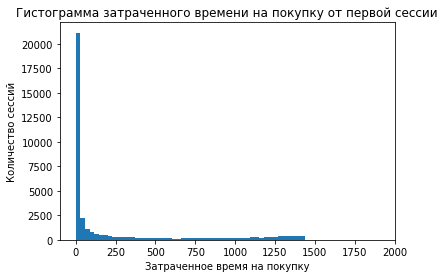

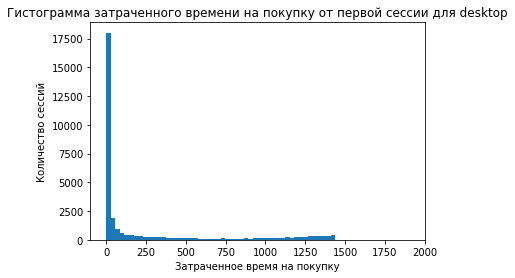

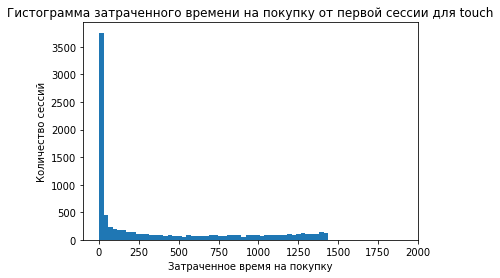

In [35]:
for data in [buying_time, buying_time_desktop, buying_time_touch]:
    
    if data is buying_time:
        plt.title('Гистограмма затраченного времени на покупку от первой сессии')
    if data is buying_time_desktop:
        plt.title('Гистограмма затраченного времени на покупку от первой сессии для desktop')
    if data is buying_time_touch:
        plt.title('Гистограмма затраченного времени на покупку от первой сессии для touch')
    plt.hist(data['buying_time'], bins=50)
    plt.xlabel('Затраченное время на покупку')
    plt.ylabel('Количество сессий')
    plt.xlim(-100,2000)
    plt.show()

На гистаграмме обнаружился интересный артефакт - очень много нулевых значений. Предположительно это связано с тем, что некоторые сайты концертов/театров/музыкальных групп интегрируют Яндекс.Афиши на свой сайт (то есть прямого захода на наш ресурс нет), поэтому такие значения могут существенно ухудшить нашу аналитику. Посчитаем их количество.



In [36]:
buying_time[buying_time['buying_time'] == 0]['start_ts'].count()

2467

2467 значений - это больше допустимых 5%. Уберём их из нашей таблицы и посмотрим на новое описание describe.


Время совершения до первой покупки для всех сессий


count    34056.000000
mean       267.214059
std        439.584023
min          1.000000
25%          5.000000
50%         20.000000
75%        310.000000
max       1439.000000
Name: buying_time, dtype: float64

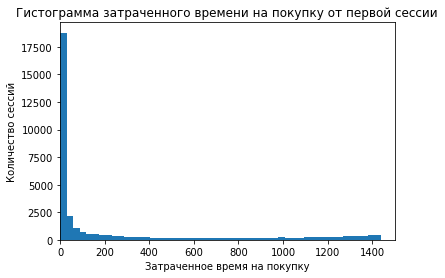



Время совершения до первой покупки для desktop


count    28626.000000
mean       260.104101
std        438.916474
min          1.000000
25%          5.000000
50%         18.000000
75%        275.000000
max       1439.000000
Name: buying_time, dtype: float64

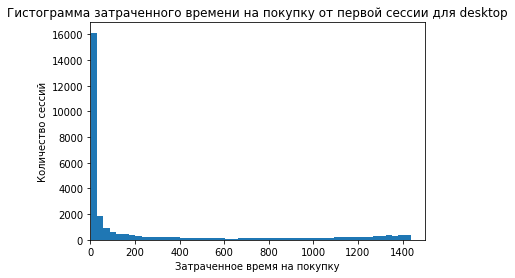



Время совершения до первой покупки для touch


count    8378.000000
mean      400.515756
std       479.825515
min         1.000000
25%         8.000000
50%       128.000000
75%       795.000000
max      1439.000000
Name: buying_time, dtype: float64

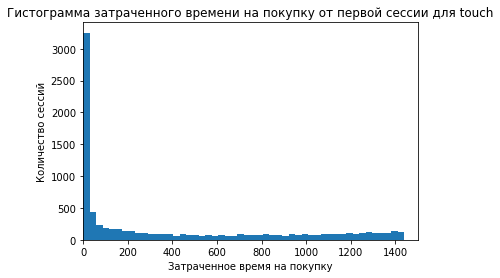



Статистическая мода для времени покупки: 1


In [37]:
print()
good_buying_time = []
for data in [buying_time, buying_time_desktop, buying_time_touch]:
    good_buying_time = data.query('buying_time > 0')
    if data is buying_time:
        print('Время совершения до первой покупки для всех сессий')
    if data is buying_time_desktop:
        print('Время совершения до первой покупки для desktop')
    if data is buying_time_touch:
        print('Время совершения до первой покупки для touch')
    display(good_buying_time['buying_time'].describe())
    
    plt.hist(good_buying_time['buying_time'], bins=50)
    plt.xlabel('Затраченное время на покупку')
    plt.ylabel('Количество сессий')
    if data is buying_time:
        plt.title('Гистограмма затраченного времени на покупку от первой сессии')
    if data is buying_time_desktop:
        plt.title('Гистограмма затраченного времени на покупку от первой сессии для desktop')
    if data is buying_time_touch:
        plt.title('Гистограмма затраченного времени на покупку от первой сессии для touch')
    plt.xlim(-1,1500)
    plt.show()
    print()
    print()
print('Статистическая мода для времени покупки:', int(good_buying_time['buying_time'].mode()))

Таким образом наши клиенты по медиане совершают покупку за **20 минут**.  
В среднем же на покупку уходит около **267 минут**, то есть эта часть пользователей заходит на сайт, серфит его какое-то время, возможно обсуждает потенциальные мероприятия со своими друзьями и уже всех этих этапов совершает покупку.  
А вот мода в **1 минуту** говорит нам о том, что очень много людей заходят с максимально точным запросом и по сути переходят сразу на экран оплаты. Это подтверждает и тепловая карта из предыдущего этапа исследования. Такие пользователи заинтересованы в конкретном мероприятии, а Яндекс.Афишу используют как кассу для выбранного события.  

Интересно, что медианное значения для покупки с *touch* составляет **128 минут**, то есть 50% пользователей *desktop* быстрее в 4,5 раза! Возможно, здесь есть ошибка подсчёта реально затраченного времени связанная с огромным количеством разных устройств и настройкой в них, то есть системы Афиши может считать, что пользователь использует приложение, а фактически оно свёрнуто в трей. Стоит сказать или просто уточнить об этом у разработчиков.


### Продажи. Сколько раз покупают за период?<a id="step3.6"></a>   
</div>

Для ответа на этот вопрос объединим таблицу **first_visit** c **orders**  методом `merge`. Выведем первые пять строк на экран

In [38]:
all_orders = orders.merge(first_visit)
all_orders_desktop = orders.merge(first_visit_desktop)
all_orders_touch = orders.merge(first_visit_touch)
for data in [all_orders, all_orders_desktop, all_orders_touch]: 
    if data is all_orders:
        print('Вcе заказы')
    if data is all_orders_desktop:
        print('Заказы с desktop')
    if data is all_orders_touch:
        print('Заказы с touch')
    display(data.head(5))

        
    print()
    print()

Вcе заказы


,uid,revenue,buy_ts,start_ts
0,10329302124590727494,17.00,2017-06-01 00:10:00,2017-06-01 00:09:00
1,11627257723692907447,0.55,2017-06-01 00:25:00,2017-06-01 00:14:00
2,17903680561304213844,0.37,2017-06-01 00:27:00,2017-06-01 00:25:00
3,16109239769442553005,0.55,2017-06-01 00:29:00,2017-06-01 00:14:00
4,14200605875248379450,0.37,2017-06-01 07:58:00,2017-06-01 07:31:00




Заказы с desktop


,uid,revenue,buy_ts,start_ts
0,10329302124590727494,17.00,2017-06-01 00:10:00,2017-06-01 00:09:00
1,11627257723692907447,0.55,2017-06-01 00:25:00,2017-06-01 00:14:00
2,17903680561304213844,0.37,2017-06-01 00:27:00,2017-06-01 00:25:00
3,16109239769442553005,0.55,2017-06-01 00:29:00,2017-06-01 00:14:00
4,14200605875248379450,0.37,2017-06-01 07:58:00,2017-06-01 07:31:00




Заказы с touch


,uid,revenue,buy_ts,start_ts
0,3644482766749211722,1.22,2017-06-01 09:22:00,2017-09-15 15:38:00
1,3644482766749211722,0.85,2017-06-02 12:44:00,2017-09-15 15:38:00
2,3644482766749211722,12.83,2017-06-02 15:08:00,2017-09-15 15:38:00
3,3644482766749211722,17.11,2017-06-04 13:06:00,2017-09-15 15:38:00
4,3644482766749211722,7.33,2017-06-07 11:06:00,2017-09-15 15:38:00


Для каждой покупки найдём день, время и месяц. 

In [39]:
for data in [all_orders, all_orders_desktop, all_orders_touch]: 
    data['buy_date'] = data['buy_ts'].dt.date
    data['buy_week'] = data['buy_ts'].dt.week
    data['buy_month'] = data['buy_ts'].dt.month


Сгруппируем покупки для каждого дня, недели и месяца.

In [40]:
buys_per_day = all_orders.groupby('buy_date')['uid'].count()
buys_per_week = all_orders.groupby('buy_week')['uid'].count()
buys_per_month = all_orders.groupby('buy_month')['uid'].count()
buys_per_day_d = all_orders_desktop.groupby('buy_date')['uid'].count()
buys_per_week_d = all_orders_desktop.groupby('buy_week')['uid'].count()
buys_per_month_d = all_orders_desktop.groupby('buy_month')['uid'].count()
buys_per_day_t = all_orders_touch.groupby('buy_date')['uid'].count()
buys_per_week_t = all_orders_touch.groupby('buy_week')['uid'].count()
buys_per_month_t = all_orders_touch.groupby('buy_month')['uid'].count()



Каждую переменную опишем методом describe и соберём их в один датафрейм.

In [41]:
orders_per_period = pd.DataFrame()
orders_per_period_d = pd.DataFrame()
orders_per_period_t = pd.DataFrame()

print('Покупки для каждого дня, недели, месяца')
orders_per_period['per_day'] = buys_per_day.describe()
orders_per_period['per_week'] = buys_per_week.describe()
orders_per_period['per_month'] = buys_per_month.describe()
display(orders_per_period[1:9].round(2))

print()
print()

print('Покупки для каждого дня, недели, месяца для desktop')
orders_per_period_d['per_day'] = buys_per_day_d.describe()
orders_per_period_d['per_week'] = buys_per_week_d.describe()
orders_per_period_d['per_month'] = buys_per_month_d.describe()
display(orders_per_period_d[1:9].round(2))

print()
print()

print('Покупки для каждого дня, недели, месяца для touch')
orders_per_period_t['per_day'] = buys_per_day_t.describe()
orders_per_period_t['per_week'] = buys_per_week_t.describe()
orders_per_period_t['per_month'] = buys_per_month_t.describe()
display(orders_per_period_t[1:9].round(2))

print()
print()



Покупки для каждого дня, недели, месяца


,per_day,per_week,per_month
mean,138.50,969.52,4201.25
std,76.86,397.63,1511.86
min,1.00,314.00,1807.00
25%,82.75,658.50,3045.50
50%,136.00,997.50,4533.50
75%,177.00,1270.50,5409.25
max,814.00,1894.00,6218.00




Покупки для каждого дня, недели, месяца для desktop


,per_day,per_week,per_month
mean,118.65,830.58,3599.17
std,67.09,341.64,1291.36
min,1.00,270.00,1572.00
25%,70.75,569.00,2641.50
50%,114.00,848.00,3845.50
75%,152.50,1086.00,4635.25
max,727.00,1644.00,5326.00




Покупки для каждого дня, недели, месяца для touch


,per_day,per_week,per_month
mean,35.12,245.15,1062.33
std,21.73,108.54,410.70
min,4.00,71.00,436.00
25%,21.00,165.25,731.00
50%,34.00,235.50,1099.00
75%,45.00,331.50,1413.00
max,251.00,549.00,1632.00


Как и ожидалось с *desktop* заказы совершают в **3,5 раза** чаще, чем с *touch*

### Продажи. Какой средний чек?<a id="step3.7"></a>   
</div>

С помощью `describe` посмотрим на столбец выручки и создадим `order_month`.

In [42]:
for data in [all_orders, all_orders_desktop, all_orders_touch]:
    if data is all_orders:
        print('Вcе заказы')
    if data is all_orders_desktop:
        print('Заказы с desktop')
    if data is all_orders_touch:
        print('Заказы с touch')    
    display(data['revenue'].describe())
    data['order_month'] = data['buy_ts'].astype('datetime64[M]').dt.date
    print()
    print()

Вcе заказы


count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64



Заказы с desktop


count    43190.000000
mean         5.197312
std         23.417780
min          0.000000
25%          1.280000
50%          2.690000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64



Заказы с touch


count    12748.000000
mean         4.785987
std         10.765277
min          0.000000
25%          1.220000
50%          2.440000
75%          4.890000
max        273.780000
Name: revenue, dtype: float64

Рассмотрим среднюю выручку по месяцам.

In [43]:
buys_per_month_mean = all_orders.groupby('order_month').agg({'revenue': 'mean'}).reset_index()
buys_per_month_mean_d = all_orders_desktop.groupby('order_month').agg({'revenue': 'mean'}).reset_index()
buys_per_month_mean_t = all_orders_desktop.groupby('order_month').agg({'revenue': 'mean'}).reset_index()


Построим линейчатую диаграмму для средней выручки с разбивкой по месяцам 

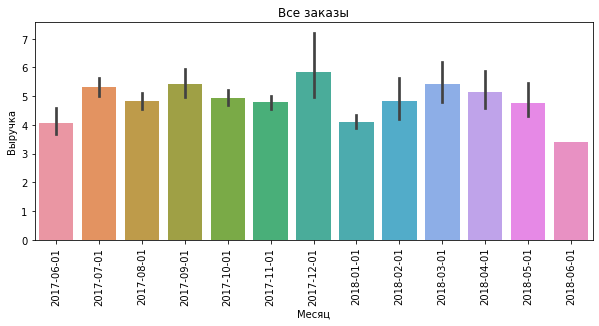

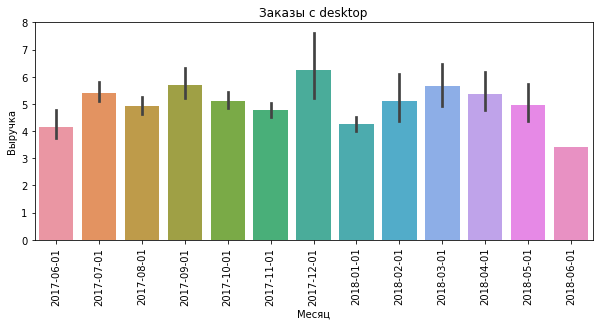

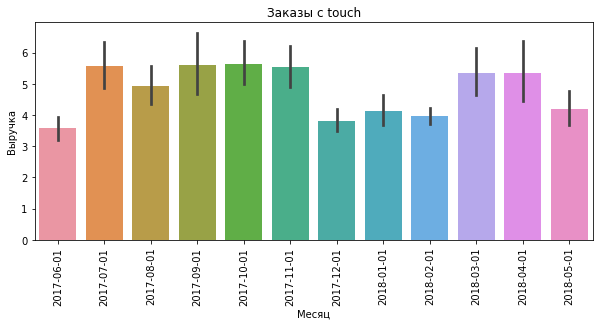

In [44]:
for data in [all_orders, all_orders_desktop, all_orders_touch]:
    plt.subplots(figsize=(10, 4))
    sns.barplot(data = data, x = 'order_month', y = 'revenue')
    if data is all_orders:
        plt.title('Вcе заказы')
    if data is all_orders_desktop:
        plt.title('Заказы с desktop')
    if data is all_orders_touch:
        plt.title('Заказы с touch')
    plt.ylabel('Выручка')
    plt.xlabel('Месяц')
    plt.xticks(rotation=90)
    plt.show()

Как видно из получившихся таблиц, в данном случае лучше ориентироваться именно на медианное значение **2.5**, так как среднее лежит в 4 квартиле. 

Анализ по месяцам не показал принципиальной сезонности. Можно отметить небольшой всплеск покупок в декабре, что можно объяснить новогодними праздниками.   

Интересный инсайт с *touch* устройств зимой соершается значительно меньше заказов. Пользователи берегут аккумуляторы!


### Продажи. Сколько денег приносят? (LTV) <a id="step3.8"></a>   
</div>

Выделим месяцы из дат в **orders** и **costs**

In [45]:
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
costs['month'] = costs['date'].astype('datetime64[M]')


Получим первый месяц покупки и выведем его на экран

In [46]:
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
display(first_orders.head())


,uid,first_order_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01


Посчитаем количество новых покупателей `n_buyers` за каждый месяц

In [47]:
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
display(cohort_sizes.head(5))

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


Строим когорты. Добавляем месяц первой покупки для каждого покупателя

In [48]:
orders_new = pd.merge(orders,first_orders, on='uid')
display(orders_new.head(5))

,uid,revenue,buy_ts,order_month,first_order_month
0,10329302124590727494,17.00,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,11627257723692907447,0.55,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,17903680561304213844,0.37,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,16109239769442553005,0.55,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,14200605875248379450,0.37,2017-06-01 07:58:00,2017-06-01,2017-06-01


Сгруппируем таблицу заказаов по месяцу первой покупки и имесяцу каждого заказа и сложим вырчку. Дополнительно спросим индексы методом `reset_index`

In [49]:
cohorts = orders_new.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
display(cohorts.head())

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


Добавим в таблицу `cohorts` данные о том, сколько людей первый раз совершили покупку в каждый месяц

In [50]:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
display(report.head())

,first_order_month,n_buyers,order_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


Найдём "возраст" когорт. Примем `margin_rate` за 1.

In [51]:
margin_rate = 1
    
report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
display(report.head())

,first_order_month,n_buyers,order_month,revenue,gp,age
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0
1,2017-06-01,2023,2017-07-01,981.82,981.82,1
2,2017-06-01,2023,2017-08-01,885.34,885.34,2
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4


Теперь найдем непосредственно `LTV` и для наглядности выведем его в сводной таблице

In [52]:
report['ltv'] = report['gp'] / report['n_buyers']
    
output_ltv = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round(2)
    
display(output_ltv)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,0.49,0.44,0.95,1.02,0.74,0.95,0.58,0.55,0.61,0.57,0.26
2017-07-01,6.01,0.34,0.62,0.36,0.18,0.16,0.12,0.14,0.16,0.15,0.16,NaN
2017-08-01,5.28,0.47,0.46,0.39,0.49,0.28,0.21,0.41,0.29,0.19,NaN,NaN
2017-09-01,5.64,1.12,0.52,3.98,0.40,0.65,0.70,0.24,0.18,NaN,NaN,NaN
2017-10-01,5.00,0.54,0.19,0.16,0.15,0.12,0.08,0.12,NaN,NaN,NaN,NaN
2017-11-01,5.15,0.40,0.20,0.32,0.15,0.05,0.11,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.74,0.26,0.93,1.07,0.31,0.34,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.14,0.29,0.30,0.14,0.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.16,0.28,0.08,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Дополнительно построим сводную таблицу с `revenue`. 

In [53]:
output_revenue = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='revenue', 
        aggfunc='mean').round()
    
display(output_revenue.cumsum(axis=1))

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,9557.0,10539.0,11424.0,13355.0,15424.0,16912.0,18835.0,20012.0,21131.0,22357.0,23513.0,24033.0
2017-07-01,11558.0,12203.0,13402.0,14092.0,14432.0,14732.0,14963.0,15236.0,15546.0,15829.0,16128.0,NaN
2017-08-01,7229.0,7876.0,8504.0,9040.0,9717.0,10105.0,10394.0,10949.0,11349.0,11607.0,NaN,NaN
2017-09-01,14569.0,17453.0,18798.0,29060.0,30094.0,31764.0,33575.0,34203.0,34678.0,NaN,NaN,NaN
2017-10-01,21716.0,24041.0,24872.0,25554.0,26212.0,26734.0,27102.0,27603.0,NaN,NaN,NaN,NaN
2017-11-01,21036.0,22665.0,23479.0,24805.0,25409.0,25629.0,26098.0,NaN,NaN,NaN,NaN,NaN
2017-12-01,20767.0,21908.0,25963.0,30632.0,32004.0,33486.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,13949.0,14943.0,15969.0,16451.0,16662.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,15177.0,16193.0,16480.0,16751.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Посчитаем **CAC** и **LTV** для когорты *2017-06-01*. 

In [54]:
cohort_20170601 = report[report['first_order_month'] == '2017-06-01']
n_buyers_20170601 = cohort_20170601['n_buyers'][0]
costs_20170601 = costs[costs['month'] == '2017-06-01']['costs'].sum()
cac_20170601 = costs_20170601 / n_buyers_20170601
ltv_20170601 = output_ltv.loc['2017-06-01'].sum()
print('CAC 1 когорты =', cac_20170601.round(3))
print('LTV 1 когорты =', ltv_20170601.round(3))

CAC 1 когорты = 8.905
LTV 1 когорты = 11.88


С учётом взятого коэффициента маржинальности **LTV** превышает **CAC**, что говорит нам вложения в эту когорту окупились. 

Теперь посмотрми, сколько нужно каждой когорте, чтобы выйти на окупаемость. Найдём суммарные расходы за каждый месяц и поделим им на количество покупателей в когорте.  

Добавим эти данные в наш отчёт `report_new` и посчитаем **CAC**.  

И затем найдём **ROMI**, поделив **LTV** на **CAC**. Выведем получившуюся сводную таблицу.





In [55]:
monthly_costs = costs.groupby('month').sum()
report_new = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new.head()
report_new['romi'] = report_new['ltv'] / report_new['cac']
output_romi = report_new.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean')

output_romi.cumsum(axis=1).round(2)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,NaN
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68,0.70,0.74,0.77,0.78,NaN,NaN
2017-09-01,0.60,0.72,0.77,1.19,1.23,1.30,1.38,1.40,1.42,NaN,NaN,NaN
2017-10-01,0.60,0.66,0.68,0.70,0.72,0.74,0.75,0.76,NaN,NaN,NaN,NaN
2017-11-01,0.55,0.60,0.62,0.65,0.67,0.68,0.69,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.54,0.57,0.68,0.80,0.84,0.87,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.42,0.45,0.48,0.49,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.46,0.49,0.50,0.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Из сводной таблицы можно обратить внимание, что первая когорта вышла на самоокупаемость на **7 месяц**, а более успешной была только 4 когорта. Её период самокупаемости составил 4 месяца, а существенный доход мы получили как раз в новогодние праздники.

Остальные когорты были менее успешны и лишь подбираются к самоокупаемости. 

Теперь найдём **среднюю когорту**. Усредним **ROMI** всех когорт за каждый месяц. 

In [56]:
display(output_romi.cumsum(axis=1).mean(axis=0))

age
0     0.540816
1     0.581985
2     0.631069
3     0.719740
4     0.782946
5     0.859876
6     0.896819
7     0.969951
8     1.053871
9     0.964488
10    1.094658
11    1.333982
dtype: float64

Как видно из получившеся таблицы, **средняя когорта** окупилась только к **9 месяцу**. После чего колебалась около окупаемости в **10-11** месяцах и к **12** вышла на стабильную окупаемость.  

### Маркетинг. Сколько денег потратили? Всего / на каждый источник / по времени (LTV) <a id="step3.9"></a>   
</div>

Просуммируем `costs` в **costs**, тем самым найдем **общие затраты** на маркетинг

In [57]:
total_costs = costs['costs'].sum()
print('Всего на маркетинг потрачено', total_costs)

Всего на маркетинг потрачено 329131.62


Теперь соберём статистику по **каждому источнику**, сгруппируем **costs** по `source_id`

In [58]:
costs_by_src = costs.groupby('source_id')['costs'].sum().reset_index()
display(costs_by_src)

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


Найдем траты по источникам в процентах и отсортируем по убыванию


In [59]:
costs_by_src['%'] = (costs_by_src['costs'] / total_costs * 100).round(2)
display(costs_by_src.sort_values('costs', ascending = False))

,source_id,costs,%
2,3,141321.63,42.94
3,4,61073.60,18.56
4,5,51757.10,15.73
1,2,42806.04,13.01
0,1,20833.27,6.33
6,10,5822.49,1.77
5,9,5517.49,1.68


Больше всего потратили на **3 источник**. Затем идёт группа из **4, 5 и 2 источников**. Меньше всего на **10 и 9** источники. И, как и было выявлено ранее, трат на **6 и 7 источники** не было. 

Теперь проанализируем траты **по месяцам**. Для этого сгруппируем **costs** по месяцам, предварительно приведём `date` к формату `datetime64[M]`

In [60]:
costs['costs_month'] = costs['date'].astype('datetime64[M]').dt.date
costs_by_month = costs.groupby('costs_month')['costs'].sum().reset_index()
display(costs_by_month)

,costs_month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


Построим линейчатую диаграмму средних затрат с разбивкой по месяцам

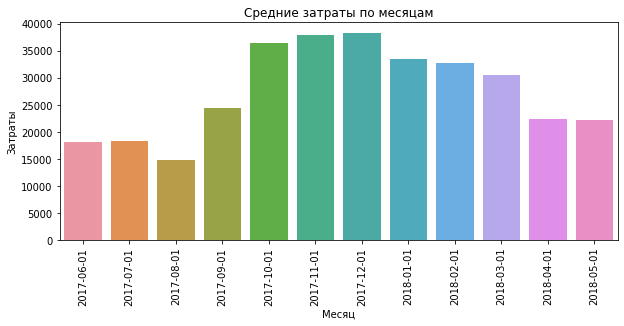

In [61]:
plt.subplots(figsize=(10, 4))
sns.barplot(data = costs_by_month, x = 'costs_month', y = 'costs')

plt.title('Средние затраты по месяцам')
plt.xticks(rotation=90) 
plt.ylabel('Затраты')
plt.xlabel('Месяц')

plt.show()

Как видим, маркетологи, как и мы, отмечают активность пользователей ближе к концу года, поэтому затраты увеличиваются начиная с сентября и растут до декабря. Затем идёт планомерное падение и после мартовских праздников траты значительно уменьшаются. 

### Маркетинг. Сколько стоило привлечение одного покупателя из каждого источника <a id="step3.10"></a>   
</div>

Сгруппируем **costs** по источнику

In [62]:
costs_by_src = costs.groupby('source_id').agg({'costs':'sum'})


Сделаем срез **visits**, где дата совпадает с датой первой сессии. И объединим получившийся срез с **orders** по **uid**. После чего сгруппируем получившуюся таблицу `buyers_by_src` по источнику. 

In [63]:
visits_by_src = visits.query('start_ts == first_visit_date')
buyers_by_src = orders.merge(visits_by_src, on='uid', how='inner')
buyers_by_src = buyers_by_src.groupby('source_id').agg({'uid':'nunique'})



Теперь найдём **CAC**. Предварительно методом `join` соединим `costs_by_src` и `buyers_by_src`. Помня про **6 и 7 источник** заполним  отсутствующие значения нулями методом `fillna`

In [64]:
cac_by_src = buyers_by_src.join(costs_by_src).reset_index()



cac_by_src['cac'] = (cac_by_src['costs'] / cac_by_src['uid']).round(2)
cac_by_src = cac_by_src.fillna(0)

display(cac_by_src)

,source_id,uid,costs,cac
0,1,2899,20833.27,7.19
1,2,3506,42806.04,12.21
2,3,10473,141321.63,13.49
3,4,10296,61073.60,5.93
4,5,6931,51757.10,7.47
5,7,1,0.00,0.00
6,9,1088,5517.49,5.07
7,10,1329,5822.49,4.38


Построим линейчатую диаграмму для **CAC** по источникам

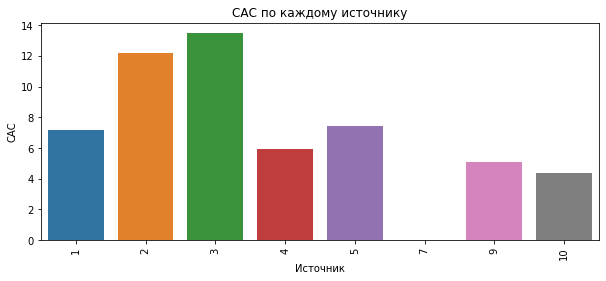

In [65]:
plt.subplots(figsize=(10, 4))
sns.barplot(data = cac_by_src, x = 'source_id', y = 'cac')

plt.title('CAC по каждому источнику')
plt.xticks(rotation=90) 
plt.ylabel('CAC')
plt.xlabel('Источник')

plt.show()

Мы видим двух однозначных лидеров: **3 и 2** источники с **CAC** равным 13,49 и 12,21 соответственно.. За ними идут **1 и 5** источники. Хуже всего дела обстоят с **10** источником. Его **CAC** составляет всего лишь 4,38 

### Маркетинг. На сколько окупились расходы? (ROI) <a id="step3.11"></a>   
</div>

In [66]:
revenue_by_src = orders.merge(visits_by_src, on='uid', how='inner')
revenue_by_src = revenue_by_src.groupby(['source_id']).agg({'revenue':'sum'})


In [67]:
roi_by_src = revenue_by_src.join(costs_by_src)
roi_by_src['roi'] = ((roi_by_src['revenue'] - roi_by_src['costs']) / roi_by_src['costs']).round(2)

display(roi_by_src)

print('Среднее ROI по всем источникам:', roi_by_src['roi'].mean())

,revenue,costs,roi
source_id,,,
1,31090.55,20833.27,0.49
2,46923.61,42806.04,0.10
3,54511.24,141321.63,-0.61
4,56696.83,61073.60,-0.07
5,52624.02,51757.10,0.02
7,1.22,NaN,NaN
9,5759.40,5517.49,0.04
10,4450.33,5822.49,-0.24


Среднее ROI по всем источникам: -0.03857142857142857


По **ROI** наш фаворит - **первый источник**. В пять раз хуже него, но всё-таки в плюсе **2** источник. А вот **3** напротив имеет отрицательный показатель.   
Здесь, скорее всего, подвело желание получить как можно больше клиентов. Если с **4** и **5** источникам баланс почти удалось удержать (при небольшом минусе и плюсе соответственно), то **3** источник провалился достаточно значительно. 

Посмотрим на доход от каждого источника и устройства отдельно

In [68]:
revenue_by_src_and_device = orders.merge(visits_by_src, on='uid', how='inner')
revenue_by_src_and_device = revenue_by_src_and_device.groupby(['source_id', 'device']).agg({'revenue':'sum'})
display(revenue_by_src_and_device)
revenue_by_src_and_device_rst = revenue_by_src_and_device.reset_index()


revenue
source_id device           
1         desktop  25995.60
          touch     5094.95
2         desktop  40386.63
          touch     6536.98
3         desktop  46273.75
          touch     8237.49
4         desktop  43414.96
          touch    13281.87
5         desktop  46825.34
          touch     5798.68
7         desktop      1.22
9         desktop   4866.41
          touch      892.99
10        desktop   3565.86
          touch      884.47

Для наглядности построим линейчатую диаграмму с разбивкой по `device`

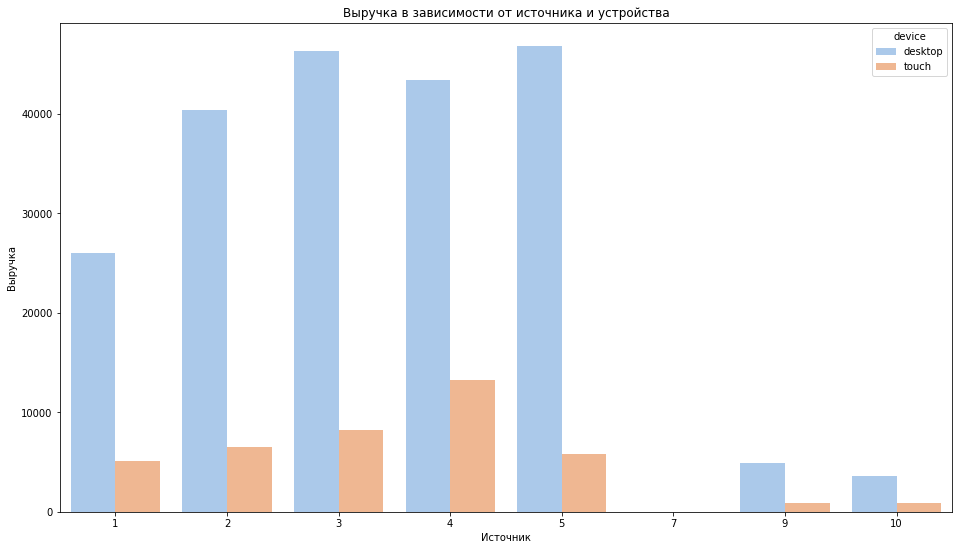

In [69]:
plt.figure(figsize = (16, 9))
sns.barplot(data=revenue_by_src_and_device_rst,
            x = 'source_id',
            y = 'revenue',
            hue='device',
            palette='pastel')

plt.title('Выручка в зависимости от источника и устройства')
plt.xlabel('Источник')
plt.ylabel('Выручка')
plt.show()

Собёрем эту таблицу иначе, убрав из выборки 7 источник. Посчитаем соотношение между *desktop* и *touch* **revenue**. Добавим общий **roi_by_src** (также предварительно уберём 7 источник). Выведем две таблицы: с сортировкой по **ratio** и **roi**.

In [70]:
revenue_desktop = revenue_by_src_and_device.query('device == "desktop" and source_id != 7')
revenue_touch = revenue_by_src_and_device.query('device == "touch"')

revenue_all = revenue_desktop.merge(revenue_touch, on = 'source_id')

revenue_all.columns = ['desktop_revenue', 'touch_revenue']
revenue_all['ratio'] = (revenue_all['touch_revenue'] / revenue_all['desktop_revenue']).round(2)



roi_by_src_and_device_by_ratio = (revenue_all.merge(roi_by_src.query('source_id != 7'), on = 'source_id').sort_values(by = 'ratio', ascending = False))

print('Сортировка по соотношению между touch и desktop')
display(roi_by_src_and_device_by_ratio)
print()
print()

roi_by_src_and_device_by_roi = roi_by_src_and_device_by_ratio.sort_values(by = 'roi', ascending = False)
print('Сортировка по ROI')
display(roi_by_src_and_device_by_roi)



Сортировка по соотношению между touch и desktop


,desktop_revenue,touch_revenue,ratio,revenue,costs,roi
source_id,,,,,,
4,43414.96,13281.87,0.31,56696.83,61073.60,-0.07
10,3565.86,884.47,0.25,4450.33,5822.49,-0.24
1,25995.60,5094.95,0.20,31090.55,20833.27,0.49
3,46273.75,8237.49,0.18,54511.24,141321.63,-0.61
9,4866.41,892.99,0.18,5759.40,5517.49,0.04
2,40386.63,6536.98,0.16,46923.61,42806.04,0.10
5,46825.34,5798.68,0.12,52624.02,51757.10,0.02




Сортировка по ROI


,desktop_revenue,touch_revenue,ratio,revenue,costs,roi
source_id,,,,,,
1,25995.60,5094.95,0.20,31090.55,20833.27,0.49
2,40386.63,6536.98,0.16,46923.61,42806.04,0.10
9,4866.41,892.99,0.18,5759.40,5517.49,0.04
5,46825.34,5798.68,0.12,52624.02,51757.10,0.02
4,43414.96,13281.87,0.31,56696.83,61073.60,-0.07
10,3565.86,884.47,0.25,4450.33,5822.49,-0.24
3,46273.75,8237.49,0.18,54511.24,141321.63,-0.61


Таблицы выше ярко иллюстрируют известный факт: ***во всём нужен баланс***. Нельзя просто гнаться за количеством, что доказывает нам **третий источник**. Если пытаться выжимать как можно больше выручки из мобильных устройств, то это также ни к чему хорошему не приведет, как показывают нам **4 и 10 источники**. **Первый источник** следует этим правилам и остаётся самым успешным.

### Шаг 4. Общий вывод  <a id="step4"></a>   
</div>  


В рамках нашего исследования мы проверили полученные датасеты. Проанализировали их на предмет пропущенных значений и дубликатов. Привели даты к нужному формату. Провели наличие (и подтвердили их отсутствие) артефактов в полях `device, source_id`. 


|               | Общая аудитория Яндекс.Афиши, человек| Аудитория Desktop, человек| Аудитория Touch, человек|
| ------------- |:------------------------------:| :------------------------:| :----------------------:| 
| Ежедневная    | 907| 659 | 252 | 
| Еженедельная  | 5 825| 4 208 | 1 666 |  
| Ежемесячная   | 23 228| 16 724 | 6 825 | 

#### Выводы по продукту: 
- В день совершается около 987 сессий. 
- Медианная продолжительность одной сессии: 300 секунд
- Сессии с мобильных устройств значительно короче сессий со станционарных (180 секунд против 360)
- В 92% и более случаев люди не возвращаются за повторной покупкой. Для мобильных устройств этот процент увеличивается до 95%


#### Выводы по продажам 
- 20 минут - медианная продолжительность от захода на сайт до покупки. С телефонов эта продолжительность составляет 128 минут. На этот факт нужно обратить внимание разработчиков. 
- В день совершается 138 покупок. В неделю - 959 покупок. В месяц - 4201 покупка.
- Средний чек - 5 у.е. Но лежит он в 4 квартиле распределения. Рекомендуем ориентироваться на медианное значение - 2,5 у.е.
- LTV первой когорты - 11.88, CAC - 8.9. Окупилась за 7 месяцев.
- Среднестатистическая когорта окупается к 11 месяцу. Особо удачная 4 когорта окупилась за 4 месяца. 

#### Выводы по маркетингу
- Маркетологи потратили 329131.62 у.е.
- Больше всего вкладывались в 3 источник.
- Маркетологи особенно усердствовали в предновогодние и предпраздничные месяцы . Их можно понять, но не чувствуются более "интересные" попытки раскрутить продукт. 
- Особенно дорогое привлечение из 2 и 3 источника. Самое дешёвое - из 10 источника. Самое интересное - из 7 источника (денег не потратили, а клиента получили).
- Общее ROI чуть ниже 0. Но есть возможности к оптимизации.

#### Рекомендации маркетологам
- В качестве гипотезы принять 1 источник как эталонный.
- Перераспределить самые большие бюджеты с 3 источника на 1 источник.
- Часть бюджета попробовать отправить на рекламу на мобильных устройствах с помощью 2 источника (гипотетически есть потенциал для роста)
- Уменьшить траты на мобильную рекламу у 4 источника. Есть дисбаланс по сравнению с 1 источником, попробовать стремиться к его показателям.
- Осознать факт, что бОльшее количество клиентов не означает бОльшую выручку для проекта. Яркий пример 3 источник.
- Не бояться отказываться от малоёмких источников (как 10 источник), если нет задачи обязательного присутствия в нём. 
- Рассмотреть возможность увеличения рекламного бюджета на мобильных устройствах с помощью 5 источника (гипотетически есть потенциал для роста)
